<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/Regularization_dropoutIRIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import libraries
import torch
import torch.nn as nn

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


<ipython-input-2-18bbc7a40f3b>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


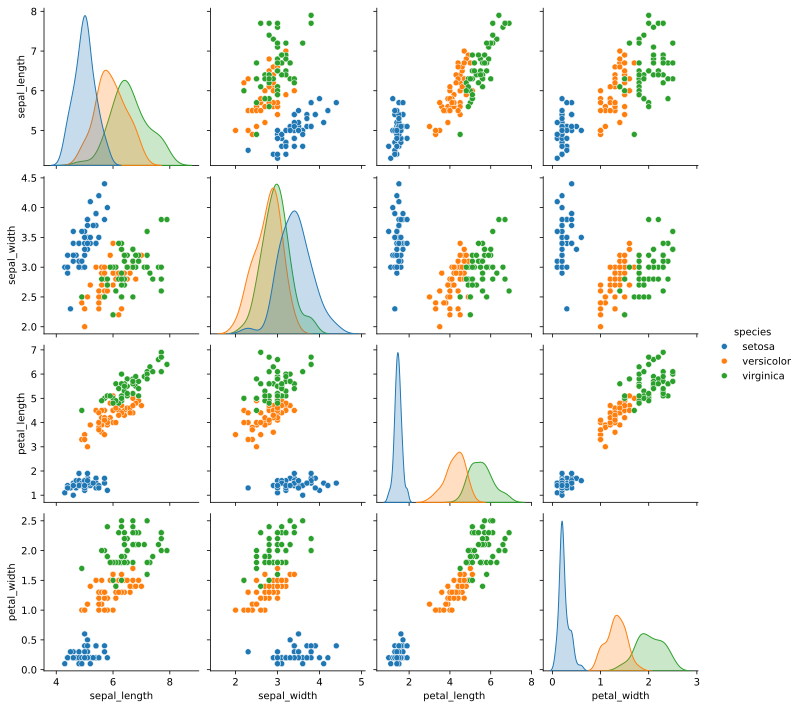

In [3]:
#import dataset(comes with seaborn)
import seaborn as sns
iris=sns.load_dataset('iris')
#check out the first few lines of data
iris.head()
#plot to show the data
sns.pairplot(iris, hue='species')
plt .show()

In [4]:
#organize the data
#convert form pandas dataframe to tensor
data=torch.tensor(iris[iris.columns[0:4]].values).float()
#transform species to number
labels=torch.zeros(len(data), dtype=torch.long)
#  0 not needed becauuse it is already initialized above
labels[iris.species=='versicolor']=1
labels[iris.species=='virginica']=2


Seperate the data into dataloader


In [5]:
#use scikitlearn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2)
#then convert them into Pytorch Datasets(note:already converted to tensors)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)
#finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

Create the model

In [6]:
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()
    ##layers
    self.input=nn.Linear(4,12)
    self.hidden=nn.Linear(12,12)
    self.output=nn.Linear(12,3)
    #parameters
    self.dr=dropoutRate
  #forwardpass
  def forward(self,x):
    #pass the data through the input layer
    x=self.input(x)
    x=F.relu(x)
    x=F.dropout(x,p=self.dr,training=self.training)#training=self.training means to true when the model
                                                   #is in train mode and false when the model is in eval mode
    #pass the data through the hidden layer
    x=self.hidden(x)
    x=F.relu(x)
    x=F.dropout(x,p=self.dr,training=self.training)
    #pass the data through the output layer
    x=self.output(x)
    #no dropout because only one hidden layer
    return x




In [7]:
#test the model with the random params
tmpnet=theModelClass(.25)
#run some random data through
tmpdata=torch.randn((10,4))
yHat=tmpnet(tmpdata)
yHat

tensor([[ 0.0176, -0.0987, -0.0975],
        [ 0.0016, -0.1470, -0.0669],
        [-0.0100, -0.1077, -0.0995],
        [ 0.1565,  0.0081, -0.2182],
        [ 0.0509, -0.0978, -0.0894],
        [-0.0397, -0.1321, -0.1646],
        [ 0.2077, -0.0394, -0.3496],
        [ 0.2565, -0.0116, -0.0212],
        [ 0.0417, -0.0326, -0.2790],
        [-0.0173, -0.1072, -0.1113]], grad_fn=<AddmmBackward0>)

Functions to create and train the net

In [15]:
def createANewModel(dropoutRate):
  #grad the instance of the model class
  ANNiris=theModelClass(dropoutrate)
  #loss function
  lossfun=nn.CrossEntropyLoss()
  #optimizer
  optimizer=torch.optim.SGD(ANNiris.parameters(),lr=0.005)
  return ANNiris,lossfun,optimizer

In [25]:
#train the model
#training parameter
numepochs=1000
#NOTE: this time, the model, lossfun and optimizer are inputs into the function
def trainTheModel(ANNiris,lossfun,optimizer):
  #initialize accuracies as empties(not storing losses here)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    #switch training mode on
    ANNiris.train()
    for X,y in train_loader :
      #forward pass and loss
      yHat=ANNiris(X)
      loss=lossfun(yHat,y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #compute accuracy
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
    #end of batch loop....
    #now that we've trained through the batches. get their training accuracy
    trainAcc.append(np.mean(batchAcc))
    #TEST ACCURACY
    ANNiris.eval()
    X,y=next(iter(test_loader))
    yHat=ANNiris(X)
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
  #function output
  return trainAcc,testAcc

TEST THE MODEL

In [26]:
#create a model
dropoutrate=.0
ANNiris,lossfun,optimizer=createANewModel(dropoutrate)
#train the model(note the inputs!)
trainAcc,testAcc=trainTheModel(ANNiris,lossfun,optimizer)


In [27]:
#create a 1D smoothing filter
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

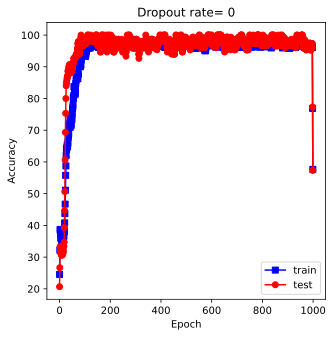

In [28]:
#plot the result
fig=plt.figure(figsize=(5,5))
plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.legend(['train','test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Dropout rate= %g'%dropoutrate)
plt.show()


Now for the test

In [29]:
#run an experiment
dropoutRates=np.arange(10)/10
results=np.zeros((len(dropoutRates),2))

#results=np.zeros(len(dropoutRates),2)
for di in range(len(dropoutRates)):
  dropoutrate=dropoutRates[di]
  ANNQC,lossfun,optimizer=createANewModel(dropoutrate)
  trainAcc,testAcc=trainTheModel(ANNQC,lossfun,optimizer)
  #store accuracies from last 100 epochs
  results[di,0]=np.mean(trainAcc[-100:])
  results[di,1]=np.mean(testAcc[-100:])

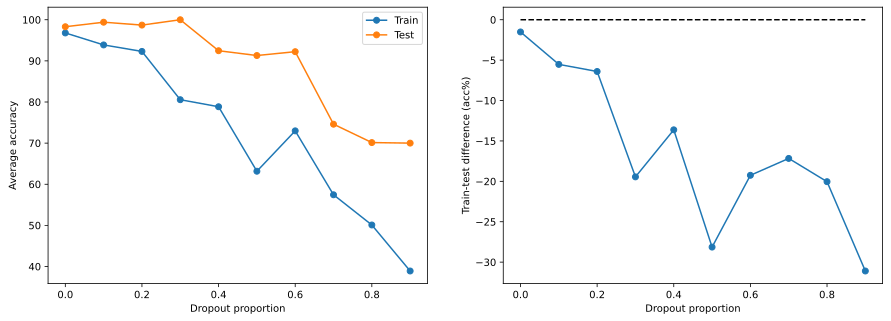

In [30]:
#plot the experiment  results
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')
plt.show()
